# 1. 라이브러리 불러오기

In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# 2. 데이터 불러오기

In [3]:
cafe_data = pd.read_csv("카페/cafedata_1101.csv")
bank_data = pd.read_csv('은행/seoul_bank_final.csv')
elementary_data = pd.read_csv('학교/school_elementary.csv')
middle_data = pd.read_csv('학교/school_middle.csv')
high_data = pd.read_csv('학교/school_high.csv')
univ_data = pd.read_csv('학교/school_university.csv')
hospital_big_data = pd.read_csv('병원/seoul_hospital_big.csv')
hospital_re_data = pd.read_csv('병원/seoul_hospital_re.csv')
subway_data = pd.read_csv('지도/subway_final.csv')
bus_data = pd.read_csv('지도/bus_final.csv')

# 3. GeoDataFrame으로 변환

In [4]:
# !pip install geopandas
# !pip install shapely

In [5]:
import geopandas as gpd
from shapely.geometry import Point
from datetime import timedelta

# GeoDataFrame으로 변환 (위도, 경도)
cafe_gdf = gpd.GeoDataFrame(cafe_data, geometry=gpd.points_from_xy(cafe_data['x'], cafe_data['y']), crs='EPSG:4326')
bank_gdf = gpd.GeoDataFrame(bank_data, geometry=gpd.points_from_xy(bank_data['x'], bank_data['y']), crs='EPSG:4326')
elementary_gdf = gpd.GeoDataFrame(elementary_data, geometry=gpd.points_from_xy(elementary_data['x'], elementary_data['y']), crs='EPSG:4326')
middle_gdf = gpd.GeoDataFrame(middle_data, geometry=gpd.points_from_xy(middle_data['x'], middle_data['y']), crs='EPSG:4326')
high_gdf = gpd.GeoDataFrame(high_data, geometry=gpd.points_from_xy(high_data['x'], high_data['y']), crs='EPSG:4326')
univ_gdf = gpd.GeoDataFrame(univ_data, geometry=gpd.points_from_xy(univ_data['x'], univ_data['y']), crs='EPSG:4326')
hospital_big_gdf = gpd.GeoDataFrame(hospital_big_data, geometry=gpd.points_from_xy(hospital_big_data['x'], hospital_big_data['y']), crs='EPSG:4326')
hospital_re_gdf = gpd.GeoDataFrame(hospital_re_data, geometry=gpd.points_from_xy(hospital_re_data['x'], hospital_re_data['y']), crs='EPSG:4326')
subway_gdf = gpd.GeoDataFrame(subway_data, geometry=gpd.points_from_xy(subway_data['x'], subway_data['y']), crs='EPSG:4326')
bus_gdf = gpd.GeoDataFrame(bus_data, geometry=gpd.points_from_xy(bus_data['x'], bus_data['y']), crs='EPSG:4326')


# 4. 좌표계 변환

In [6]:
# 좌표계 변환 (WGS84 -> UTM 혹은 다른 평면 좌표계로 변환, 여기서는 EPSG:5179 사용 예시)
cafe_gdf = cafe_gdf.to_crs(epsg=5179)
bank_gdf = bank_gdf.to_crs(epsg=5179)
elementary_gdf = elementary_gdf.to_crs(epsg=5179)
middle_gdf = middle_gdf.to_crs(epsg=5179)
high_gdf = high_gdf.to_crs(epsg=5179)
univ_gdf = univ_gdf.to_crs(epsg=5179)
hospital_big_gdf = hospital_big_gdf.to_crs(epsg=5179)
hospital_re_gdf = hospital_re_gdf.to_crs(epsg=5179)
subway_gdf = subway_gdf.to_crs(epsg=5179)
bus_gdf = bus_gdf.to_crs(epsg=5179)

# 5. 반경 내 카페 개수 구하는 함수 정의

In [7]:
def count_near(cafe_row, data_gdf, buffer):
    buffer = cafe_row.geometry.buffer(buffer)
    count = data_gdf[data_gdf.geometry.within(buffer)].shape[0]
    return count


# 6. 지역 특성 변수별 500m 이내 카페 개수 구하기

In [ ]:
data_set = [bank_gdf, elementary_gdf, middle_gdf, high_gdf, univ_gdf, hospital_big_gdf, hospital_re_gdf, subway_gdf, bus_gdf]
name = ['bank', 'elementary', 'middle', 'high', 'univ', 'hospital_big', 'hospital_re', 'subway', 'bus']

for j, data_gdf in zip(name, data_set):
    cafe_gdf[f'{j} 개수'] = cafe_gdf.apply(count_near, axis=1, data_gdf=data_gdf, buffer=500)

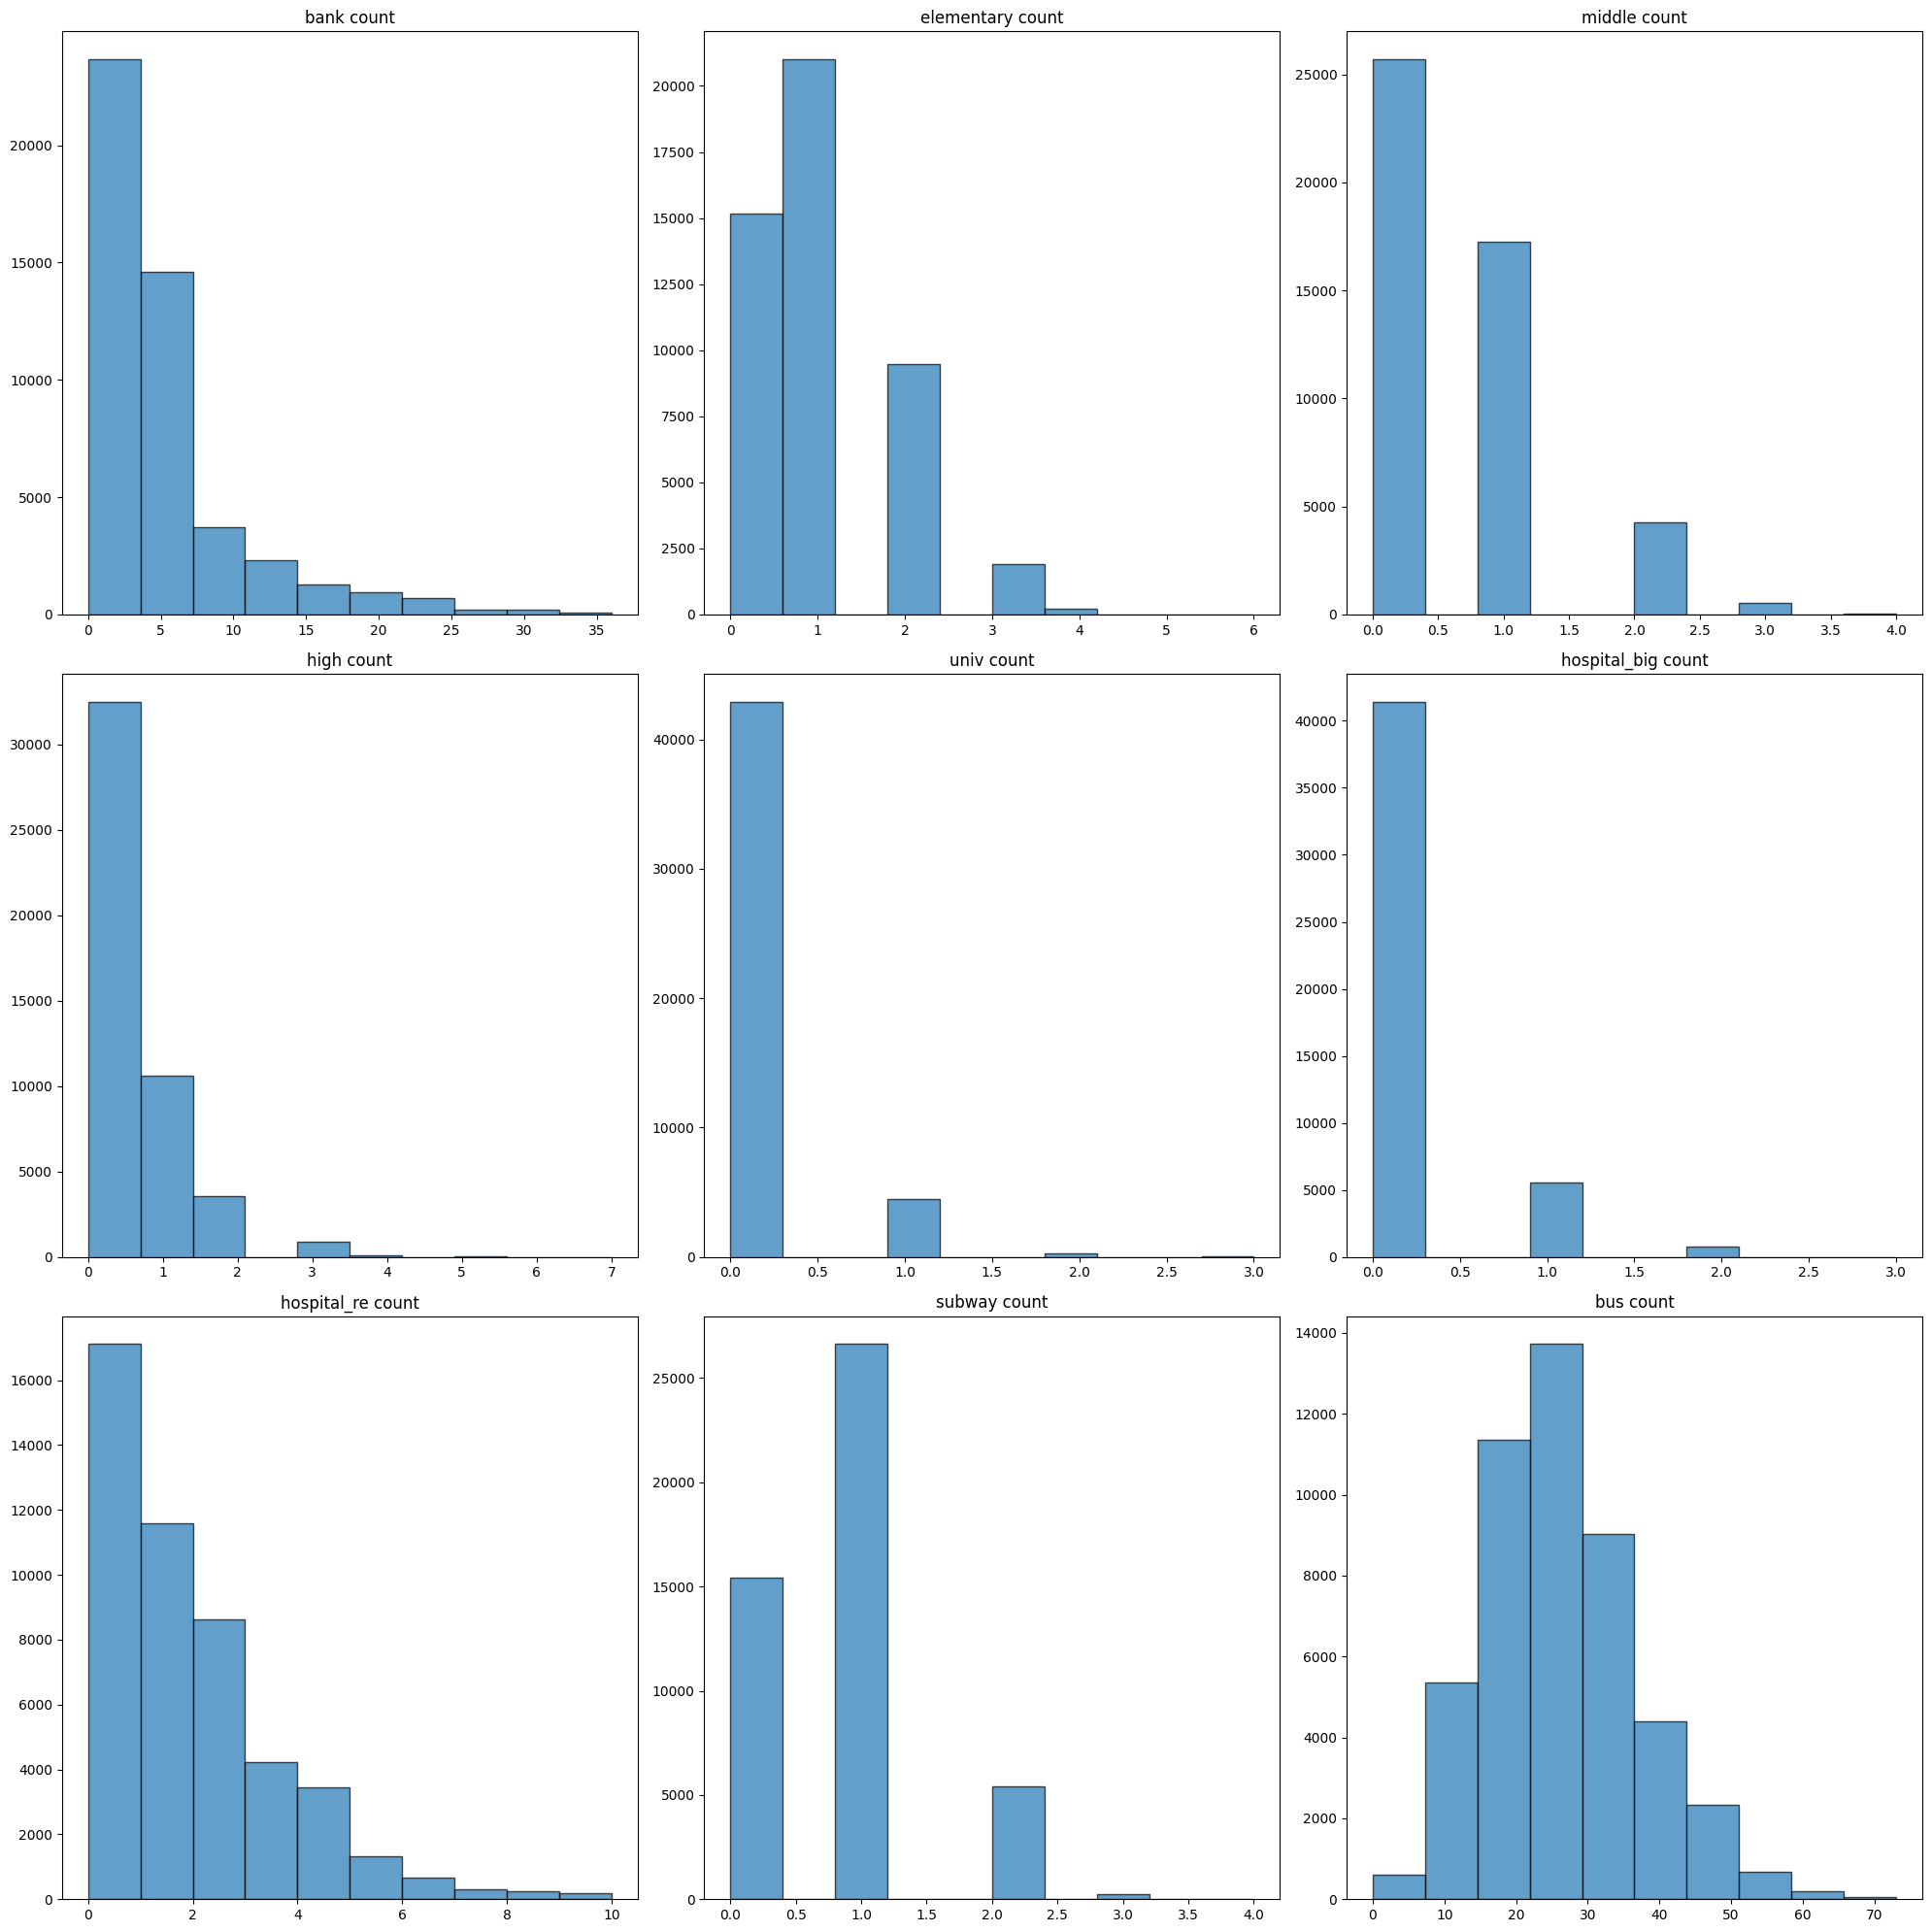

In [ ]:
# 서브플롯 생성 (2행 4열로 배치)
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
axes = axes.ravel()  # 2차원 배열을 1차원 배열로 변환

# 히스토그램 그리기
for i, j in enumerate(name):
    axes[i].hist(cafe_gdf[f'{j} 개수'], bins=10, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{j} count')

# 그래프 레이아웃 조정
plt.tight_layout()
plt.show()

In [ ]:
cafe_gdf.to_csv('최종/fianl_cafe_gdf.csv', index=False)

- 반경 계산에 가장 많이 사용되는 500m로 설정 후 계산된 데이터로 분포를 확인해본 결과, 0개가 가장 많은 변수들은 수정이 필요할 것으로 보임.
    - 고등학교 수정 필요
    - 대학교 수정 필요
    - 병원 수정 필요
        1. 종합병원급 병원(종합병원, 면적 10000m^2 이상)
        2. 일반병원(병원, 요양병원, 치과 등)
    - 지하철 수정 필요 : 카페 250m 이내 지하철역 존재여부로 역세권, 비역세권 범주형으로 변수 생성
    - 버스 수정 필요 : 카페 250m 이내 버스정류장 개수

# 7. 반경 수정

## 학교

### 고등학교 반경 재설정(800m)

In [ ]:
cafe_gdf['high_800m 개수'] = cafe_gdf.apply(count_near, axis=1, data_gdf=high_gdf, buffer=800)

In [ ]:
cafe_gdf['high_800m 개수'].value_counts()

high 개수
0    17304
1    13447
2    10076
3     4629
4     1613
5      395
6      144
7      113
8       28
Name: count, dtype: int64

(array([17304., 13447., 10076.,  4629.,     0.,  1613.,   395.,   144.,
          113.,    28.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

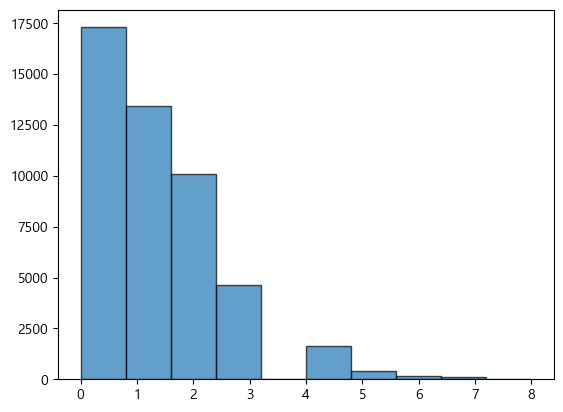

In [ ]:
plt.hist(cafe_gdf['high_800m 개수'], bins=10, edgecolor='black', alpha=0.7)

In [ ]:
cafe_gdf.drop('high 개수', axis=1, inplace=True)

### 대학교 반경 재설정(1km)

In [12]:
cafe_gdf['univ_1000m 개수'] = cafe_gdf.apply(count_near, axis=1, data_gdf=univ_gdf, buffer=1000) # 반경 1km로 재설정
cafe_gdf['univ_1000m 개수'].value_counts()

univ_1000m 개수
0    32548
1    11269
2     2984
3      795
4      151
5        2
Name: count, dtype: int64

(array([3.2548e+04, 0.0000e+00, 1.1269e+04, 0.0000e+00, 2.9840e+03,
        0.0000e+00, 7.9500e+02, 0.0000e+00, 1.5100e+02, 2.0000e+00]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

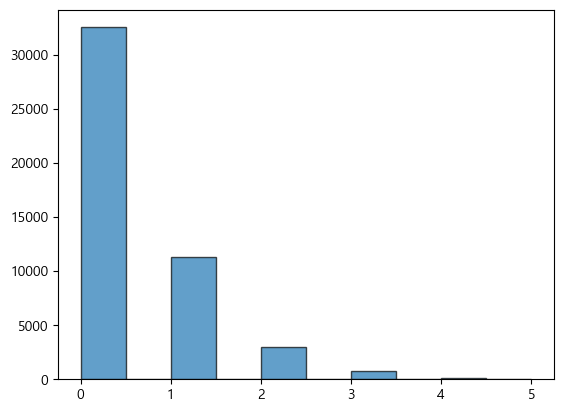

In [13]:
plt.hist(cafe_gdf['univ_1000m 개수'], bins=10, edgecolor='black', alpha=0.7)

In [ ]:
cafe_gdf.drop('univ 개수', axis=1, inplace=True)

## 버스

### 버스 반경 재설정(50m)

In [ ]:
cafe_gdf['bus 개수'] = cafe_gdf.apply(count_near, axis=1, data_gdf=bus_gdf, buffer=50) # 반경 50m로 재설정

In [ ]:
cafe_gdf['bus 개수'].value_counts()

bus 개수
0    34861
1     7684
2     3835
3      973
4      298
5       67
6       29
7        2
Name: count, dtype: int64

(array([3.4861e+04, 7.6840e+03, 3.8350e+03, 0.0000e+00, 9.7300e+02,
        2.9800e+02, 0.0000e+00, 6.7000e+01, 2.9000e+01, 2.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

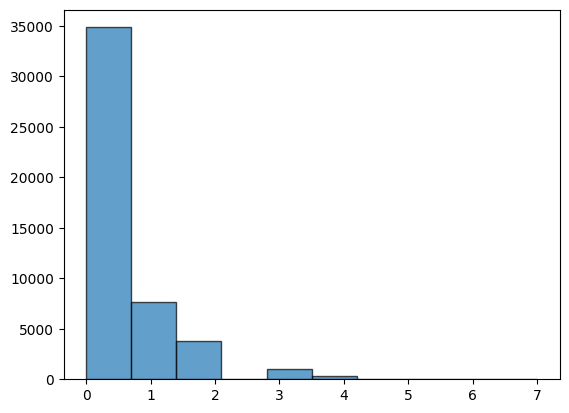

In [ ]:
plt.hist(cafe_gdf['bus 개수'], bins=10, edgecolor='black', alpha=0.7)

### 버스 반경 재설정(100m)

In [ ]:
cafe_gdf['bus_100m'] = cafe_gdf.apply(count_near, axis=1, data_gdf=bus_gdf, buffer=100)

In [ ]:
cafe_gdf['bus_100m'].value_counts()

bus_100m
0     17859
2     10300
1      8917
3      4808
4      3169
5      1377
6       700
7       315
8       126
11       85
9        50
12       24
10       19
Name: count, dtype: int64

(array([2.6776e+04, 1.0300e+04, 4.8080e+03, 3.1690e+03, 1.3770e+03,
        1.0150e+03, 1.2600e+02, 5.0000e+01, 1.9000e+01, 1.0900e+02]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

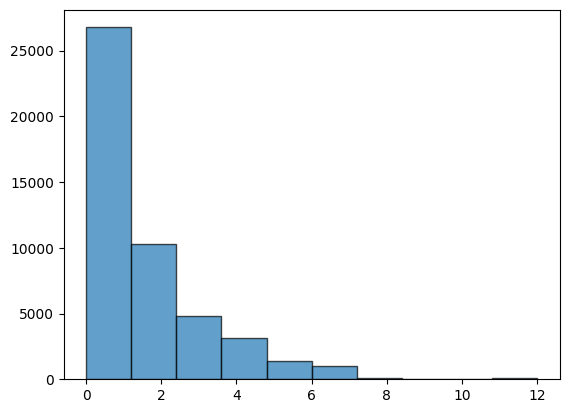

In [ ]:
plt.hist(cafe_gdf['bus_100m'], bins=10, edgecolor='black', alpha=0.7)

### 버스 반경 재설정(150m)

In [ ]:
cafe_gdf['bus_150m'] = cafe_gdf.apply(count_near, axis=1, data_gdf=bus_gdf, buffer=150)

In [ ]:
cafe_gdf['bus_150m'].value_counts()

bus_150m
2     10374
0      7277
3      6963
4      6560
1      5297
5      3822
6      2848
7      1744
8      1186
9       692
10      460
11      246
13      126
12      119
14       19
15        8
16        3
17        2
20        2
19        1
Name: count, dtype: int64

(array([1.2574e+04, 1.7337e+04, 1.0382e+04, 4.5920e+03, 1.8780e+03,
        7.0600e+02, 2.4500e+02, 2.7000e+01, 5.0000e+00, 3.0000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

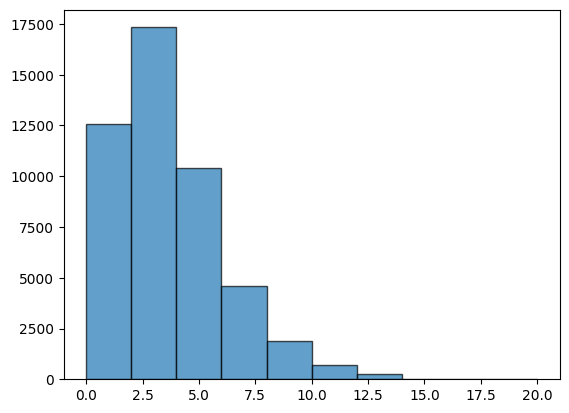

In [ ]:
plt.hist(cafe_gdf['bus_150m'], bins=10, edgecolor='black', alpha=0.7)

### 버스 반경 재설정(200m)

In [ ]:
cafe_gdf['bus_200m'] = cafe_gdf.apply(count_near, axis=1, data_gdf=bus_gdf, buffer=200) # 반경 250m로 재설정

In [ ]:
cafe_gdf['bus_200m'].value_counts()

bus_200m
4     6636
2     6375
5     5664
3     5480
6     4779
7     3857
0     2885
8     2678
1     2255
9     2056
10    1769
11     995
12     769
13     559
14     379
16     192
15     192
17     110
18      56
20      26
19      23
21       5
22       5
24       2
29       2
Name: count, dtype: int64

(array([1.1515e+04, 1.7780e+04, 1.1314e+04, 4.8200e+03, 1.7070e+03,
        4.9400e+02, 1.0500e+02, 1.0000e+01, 2.0000e+00, 2.0000e+00]),
 array([ 0. ,  2.9,  5.8,  8.7, 11.6, 14.5, 17.4, 20.3, 23.2, 26.1, 29. ]),
 <BarContainer object of 10 artists>)

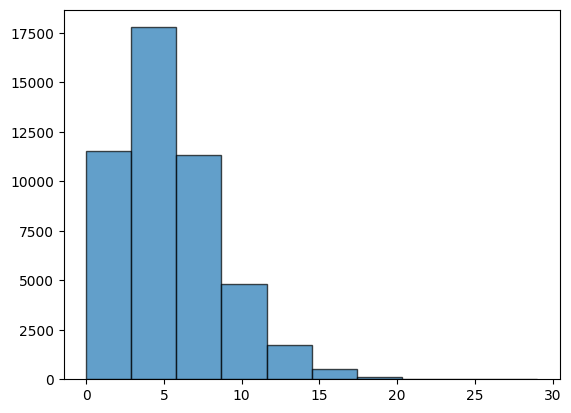

In [ ]:
plt.hist(cafe_gdf['bus_200m'], bins=10, edgecolor='black', alpha=0.7)

### 버스 반경 재설정(250m)

In [ ]:
cafe_gdf['bus_250m'] = cafe_gdf.apply(count_near, axis=1, data_gdf=bus_gdf, buffer=250)

In [ ]:
cafe_gdf['bus_250m'].value_counts()

bus_250m
4     5291
6     4674
7     4557
5     4553
8     3996
9     3649
3     3139
10    3112
2     2438
11    2255
12    2096
13    1514
14    1230
0     1106
15     910
1      762
16     712
17     550
18     461
19     204
20     172
21     127
22      79
23      35
24      32
25      30
27      30
26      13
28       6
30       6
29       5
37       2
39       2
33       1
Name: count, dtype: int64

(array([7.4450e+03, 1.9075e+04, 1.3012e+04, 5.7500e+03, 1.9270e+03,
        4.1300e+02, 1.0500e+02, 1.7000e+01, 1.0000e+00, 4.0000e+00]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <BarContainer object of 10 artists>)

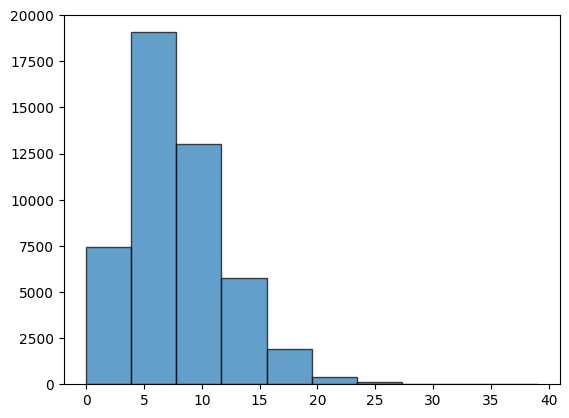

In [ ]:
plt.hist(cafe_gdf['bus_250m'], bins=10, edgecolor='black', alpha=0.7)

In [ ]:
cafe_gdf.drop(['bus 개수','bus_100m','bus_150m','bus_200m'], axis=1, inplace=True)

## 지하철

### 카페 반경 100m 내 지하철역 존재 여부

In [ ]:
cafe_gdf['subway_within_100m'] = cafe_gdf['geometry'].apply(
    lambda point: subway_gdf[subway_gdf.distance(point) <= 100].shape[0] > 0
).astype(int)

In [ ]:
cafe_gdf['subway_within_100m'].value_counts()

subway_within_100m
0    45234
1     2515
Name: count, dtype: int64

### 카페 반경 150m 내 지하철역 존재 여부

In [ ]:
cafe_gdf['subway_within_150m'] = cafe_gdf['geometry'].apply(
    lambda point: subway_gdf[subway_gdf.distance(point) <= 150].shape[0] > 0
).astype(int)

In [ ]:
cafe_gdf['subway_within_150m'].value_counts()

subway_within_150m
0    42228
1     5521
Name: count, dtype: int64

### 카페 반경 200m 내 지하철역 존재 여부

In [ ]:
cafe_gdf['subway_within_200m'] = cafe_gdf['geometry'].apply(
    lambda point: subway_gdf[subway_gdf.distance(point) <= 200].shape[0] > 0
).astype(int)

In [ ]:
cafe_gdf['subway_within_200m'].value_counts()

subway_within_200m
0    38373
1     9376
Name: count, dtype: int64

### 카페 반경 250m 내 지하철역 존재 여부

In [ ]:
cafe_gdf['subway_within_250m'] = cafe_gdf['geometry'].apply(
    lambda point: subway_gdf[subway_gdf.distance(point) <= 250].shape[0] > 0
).astype(int)

In [ ]:
cafe_gdf['subway_within_250m'].value_counts()

subway_within_250m
0    34474
1    13275
Name: count, dtype: int64

In [ ]:
cafe_gdf.drop(['subway 개수','subway_within_100m','subway_within_150m','subway_within_200m'], axis=1, inplace=True)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'

plt.hist(cafe_gdf['subway_within_250m'], width=0.5)

## 병원

### 종합병원급 반경 재설정(1km)

In [ ]:
cafe_gdf['hospital_big_1000m 개수'] = cafe_gdf.apply(count_near, axis=1, data_gdf=hospital_big_gdf, buffer=1000)

In [ ]:
cafe_gdf['hospital_big_1000m 개수'].value_counts()

hospital_big_1000m 개수
0    29655
1    13565
2     3821
3      646
4       62
Name: count, dtype: int64

(array([29655.,     0., 13565.,     0.,     0.,  3821.,     0.,   646.,
            0.,    62.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

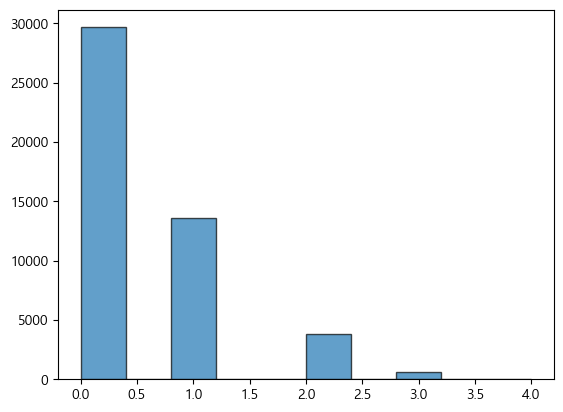

In [ ]:
plt.hist(cafe_gdf['hospital_big_1000m 개수'], bins=10, edgecolor='black', alpha=0.7)

In [ ]:
cafe_gdf.drop('hospital_big 개수', axis=1, inplace=True)

# 8. 상관계수 히트맵 그리기

(array([13651.,  8939.,  4622.,  7672.,  4786.,  3097.,  2160.,  1311.,
          932.,   579.]),
 array([1.000e+00, 5.390e+02, 1.077e+03, 1.615e+03, 2.153e+03, 2.691e+03,
        3.229e+03, 3.767e+03, 4.305e+03, 4.843e+03, 5.381e+03]),
 <BarContainer object of 10 artists>)

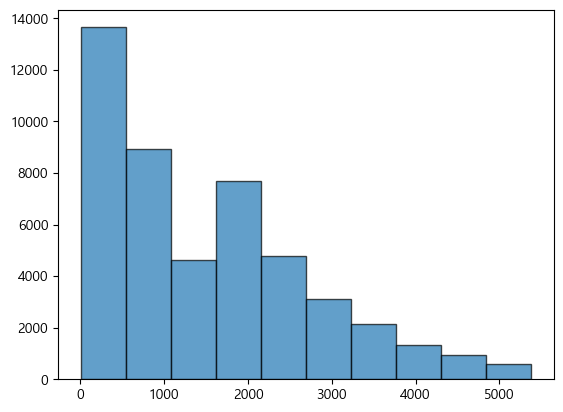

In [ ]:
from datetime import datetime

df = cafe_gdf.copy()

# 날짜타입으로 변환
df['영업자시작일'] = pd.to_datetime(df['영업자시작일'])
df['폐업일자'] = pd.to_datetime(df['폐업일자'])


# Converting dates from string to datetime format
df['영업자시작일'] = pd.to_datetime(df['영업자시작일'])
df['폐업일자'] = pd.to_datetime(df['폐업일자'], errors='coerce')

# Set a reference date for open stores (assuming today's date or a specified date like 2024-09-28)
reference_date = datetime(2024, 9, 28)

# Calculate '총 영업일' based on 폐업여부
df['총 영업일'] = df.apply(lambda row: (row['폐업일자'] - row['영업자시작일']).days if row['폐업여부'] == 1 
                           else (reference_date - row['영업자시작일']).days, axis=1)

# 히스토그램으로 확인
plt.hist(df['총 영업일'], bins=10, edgecolor='black', alpha=0.7)

In [ ]:
# 기존 총영업일 삭제
df.drop(['총영업일'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['업소명', '행정동명', '소재지도로명', '영업자시작일', '폐업일자', '총면적', '카페명', '복층여부', 'x',
       'y', '폐업여부', '카페유형', '월', '계절', 'xy_combined', 'geometry', 'bank 개수',
       'elementary 개수', 'middle 개수', 'high 개수', 'hospital_re 개수',
       'univ_1000m 개수', 'bus_250m', 'subway_within_250m',
       'hospital_big_1000m 개수', '총 영업일'],
      dtype='object')

In [ ]:
df.columns = ['업소명', '행정동명', '소재지도로명', '영업자시작일', '폐업일자', '총면적', '카페명', '복층여부', 'x',
              'y', '폐업여부', '카페유형', '월', '계절', 'xy_combined', 'geometry', 'bank_500m 개수',
              'elementary_500m 개수', 'middle_500m 개수', 'high_800m 개수', 'hospital_re_500m 개수',
              'univ_1000m 개수', 'bus_250m 개수', 'subway_250m 존재여부',
              'hospital_big_1000m 개수', '총 영업일']

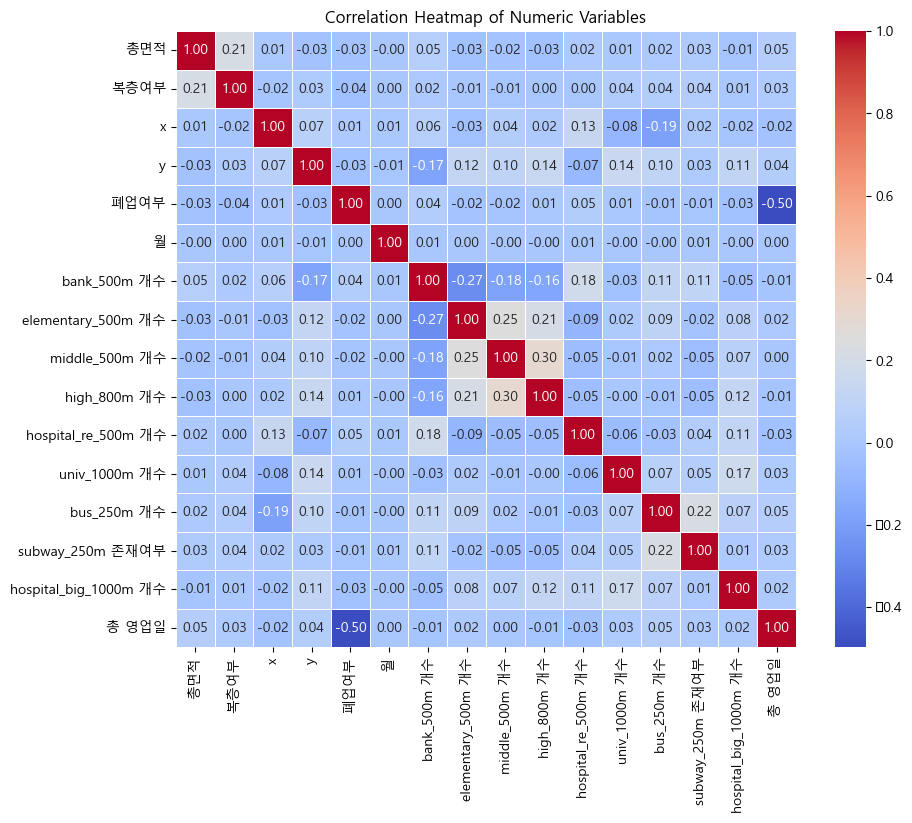

In [ ]:
# 폰트 설정 (예: 맑은 고딕, 나눔 고딕 등)
plt.rcParams["font.family"] = "Malgun Gothic"  # Windows의 경우
# plt.rcParams["font.family"] = "AppleGothic"  # macOS의 경우

# 수치형 변수만 추출하여 상관관계 계산
numeric_cafe_gdf = df.select_dtypes(include='number')
correlation_matrix = numeric_cafe_gdf.corr()

import seaborn as sns
# 상관관계 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Variables")
plt.show()

In [ ]:
df.head()

,업소명,행정동명,소재지도로명,영업자시작일,폐업일자,총면적,카페명,복층여부,x,y,...,bank_500m 개수,elementary_500m 개수,middle_500m 개수,high_800m 개수,hospital_re_500m 개수,univ_1000m 개수,bus_250m 개수,subway_250m 존재여부,hospital_big_1000m 개수,총 영업일
0,커피앤모바일,장위제1동,서울특별시 성북구 장월로 174 (장위동),2010-01-04,2010-04-02,17.36,커피앤모바일,0,127.053810,37.619456,...,1,2,2,1,0,2,20,0,0,88
1,커피사업지원센타,원효로제2동,"서울특별시 용산구 효창원로12길 37, (원효로4가,(지상1층))",2010-01-04,NaT,89.10,커피사업지원센타,0,126.952872,37.533354,...,1,1,1,1,0,0,10,0,0,5381
2,할리스커피(동덕여대점),월곡제1동,"서울특별시 성북구 화랑로11길 23-6, (하월곡동,지하1층~지상1층(지하30평,그...",2010-01-04,NaT,390.88,할리스,0,127.041656,37.603577,...,4,0,0,0,0,1,10,1,0,5381
3,카페모넬린,화양동,서울특별시 광진구 광나루로20길 36-3 (화양동),2010-01-04,2011-12-05,53.30,카페모넬린,0,127.073852,37.545336,...,1,0,0,1,0,1,4,0,1,700
4,(주)도르체비타,도곡2동,"서울특별시 강남구 언주로30길 56 (도곡동, 타워팰리스)",2010-01-05,2010-05-18,6.60,(주)도르체비타,0,127.054666,37.488555,...,11,1,3,5,0,0,6,0,1,133


In [ ]:
# df.to_csv('카페/final_1102_2100.csv', index=False)
df.to_csv('최종/final_1103.csv', index=False)

# 9. 최종 데이터셋 합치기

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
won = pd.read_csv('최종/final_1103.csv')
ju = pd.read_csv('최종/final_1102_1930.csv')
ju_csi = pd.read_csv('최종/csi_data.csv')

In [ ]:
won.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   업소명                    47749 non-null  object 
 1   행정동명                   47749 non-null  object 
 2   소재지도로명                 47749 non-null  object 
 3   영업자시작일                 47749 non-null  object 
 4   폐업일자                   19505 non-null  object 
 5   총면적                    47749 non-null  float64
 6   카페명                    47749 non-null  object 
 7   복층여부                   47749 non-null  int64  
 8   x                      47749 non-null  float64
 9   y                      47749 non-null  float64
 10  폐업여부                   47749 non-null  int64  
 11  카페유형                   47749 non-null  object 
 12  월                      47749 non-null  int64  
 13  계절                     47749 non-null  object 
 14  xy_combined            47749 non-null  object 
 15  ge

In [ ]:
ju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   업소명           47749 non-null  object 
 1   행정동명          47749 non-null  object 
 2   소재지도로명        47749 non-null  object 
 3   영업자시작일        47749 non-null  object 
 4   폐업일자          19505 non-null  object 
 5   총면적           47749 non-null  float64
 6   카페명           47749 non-null  object 
 7   복층여부          47749 non-null  int64  
 8   x             47749 non-null  float64
 9   y             47749 non-null  float64
 10  폐업여부          47749 non-null  int64  
 11  카페유형          47749 non-null  object 
 12  월             47749 non-null  int64  
 13  계절            47749 non-null  object 
 14  xy_combined   47749 non-null  object 
 15  geometry      47749 non-null  object 
 16  고가프차 개수_500m  47749 non-null  int64  
 17  저가프차 개수_500m  47749 non-null  int64  
 18  중가프차 개수_500m  47749 non-nu

In [ ]:
ju_csi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   폐업일자     19505 non-null  object 
 1   소비자물가지수  19505 non-null  float64
 2   분기       19505 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.1+ MB


In [ ]:
won_var = won.iloc[:,16:25]
ju_csi_var = ju_csi.iloc[:,1:3]

In [ ]:
final_data = pd.concat([ju,ju_csi_var, won_var], axis=1)

In [ ]:
final_data.columns

Index(['업소명', '행정동명', '소재지도로명', '영업자시작일', '폐업일자', '총면적', '카페명', '복층여부', 'x',
       'y', '폐업여부', '카페유형', '월', '계절', 'xy_combined', 'geometry',
       '고가프차 개수_500m', '저가프차 개수_500m', '중가프차 개수_500m', '스타벅스 개수_500m',
       '카페 개수_500m', '음식점 개수_500m', '총 영업일', '소비자물가지수', '분기', 'bank_500m 개수',
       'elementary_500m 개수', 'middle_500m 개수', 'high_800m 개수',
       'hospital_re_500m 개수', 'univ_1000m 개수', 'bus_250m 개수',
       'subway_250m 존재여부', 'hospital_big_1000m 개수'],
      dtype='object')

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47749 entries, 0 to 47748
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   업소명                    47749 non-null  object 
 1   행정동명                   47749 non-null  object 
 2   소재지도로명                 47749 non-null  object 
 3   영업자시작일                 47749 non-null  object 
 4   폐업일자                   19505 non-null  object 
 5   총면적                    47749 non-null  float64
 6   카페명                    47749 non-null  object 
 7   복층여부                   47749 non-null  int64  
 8   x                      47749 non-null  float64
 9   y                      47749 non-null  float64
 10  폐업여부                   47749 non-null  int64  
 11  카페유형                   47749 non-null  object 
 12  월                      47749 non-null  int64  
 13  계절                     47749 non-null  object 
 14  xy_combined            47749 non-null  object 
 15  ge

In [ ]:
final_data['영업자시작일'] = pd.to_datetime(final_data['영업자시작일'], format='mixed')
final_data['개업년도'] = final_data['영업자시작일'].dt.year

In [ ]:
final_data['개업년도'].value_counts()

개업년도
2019    5636
2018    4280
2017    4233
2016    3795
2023    3681
2014    3593
2015    3464
2022    3154
2021    2836
2024    2729
2013    2684
2012    2359
2011    2113
2010    1623
2020    1569
Name: count, dtype: int64

In [ ]:
final_data.to_csv('최종/final_dataset_1103.csv', index=False, encoding='utf-8-sig')

In [ ]:
final_data = pd.read_csv('최종/final_dataset_1103.csv')